# PASTIS Data Transformation: Max-NDVI Selection

Transform PASTIS time series data from `(43, 10, 128, 128)` → single cleanest image `(1, 10, 128, 128)`

**Process:**
1. **Calendar Filter:** Select only images from Jan 1 - April 30 (winter cereal growing season)
2. **Max-NDVI Selection:** For each pixel, select the time step with maximum NDVI (greenest = cleanest)
3. **Add Batch Dimension:** Final shape `(1, 10, 128, 128)` matching Algeria data format

**Why Max-NDVI?**
- Clouds appear white (high reflectance in all bands) → Low NDVI
- Shadows appear dark → Low NDVI  
- Healthy vegetation → High NDVI
- Selecting max NDVI naturally picks the clearest, most vegetated observation

In [1]:
# Load PASTIS metadata to get acquisition dates
import json
import numpy as np
import pandas as pd
from pathlib import Path
from datetime import datetime
from tqdm import tqdm

PASTIS_DIR = Path('/home/crop/Desktop/crop/PASTIS')
PASTIS_OUTPUT_DIR = Path('/home/crop/Desktop/crop/output/pastis_median')
PASTIS_OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Create output subdirectories
DATA_OUTPUT_DIR = PASTIS_OUTPUT_DIR / 'DATA_S2'
DATA_OUTPUT_DIR.mkdir(exist_ok=True)

# Load metadata to get dates for each patch
with open(PASTIS_DIR / 'metadata.geojson', 'r') as f:
    pastis_metadata = json.load(f)

print(f"Total PASTIS patches: {len(pastis_metadata['features'])}")

# Check the structure of metadata
sample_feature = pastis_metadata['features'][0]
print("\nSample metadata properties:")
for key, value in sample_feature['properties'].items():
    print(f"  {key}: {value}")

Total PASTIS patches: 2433

Sample metadata properties:
  Fold: 1
  ID_PATCH: 10000
  N_Parcel: 119
  Parcel_Cover: 0.8080319354330431
  TILE: t30uxv
  dates-S2: {'0': 20180924, '1': 20180929, '2': 20181004, '3': 20181009, '4': 20181019, '5': 20181024, '6': 20181029, '7': 20181108, '8': 20181113, '9': 20181118, '10': 20181123, '11': 20190117, '12': 20190122, '13': 20190216, '14': 20190221, '15': 20190226, '16': 20190313, '17': 20190328, '18': 20190412, '19': 20190422, '20': 20190427, '21': 20190512, '22': 20190527, '23': 20190601, '24': 20190606, '25': 20190621, '26': 20190626, '27': 20190701, '28': 20190706, '29': 20190711, '30': 20190716, '31': 20190731, '32': 20190810, '33': 20190815, '34': 20190820, '35': 20190825, '36': 20190830, '37': 20190904, '38': 20190914, '39': 20190919, '40': 20190924, '41': 20191009, '42': 20191019}
  id: 10000


In [2]:
# The dates are stored as a dictionary with index keys
# Parse the dates for the first patch to understand the format

sample_dates_dict = sample_feature['properties'].get('dates-S2', {})
print(f"Dates structure type: {type(sample_dates_dict)}")

# Convert dict to list (sorted by index)
if isinstance(sample_dates_dict, dict):
    sample_dates = [sample_dates_dict[str(i)] for i in range(len(sample_dates_dict))]
else:
    sample_dates = sample_dates_dict

print(f"\nNumber of dates in sample patch: {len(sample_dates)}")
print(f"First 5 dates: {sample_dates[:5]}")
print(f"Last 5 dates: {sample_dates[-5:]}")

# Convert to datetime to understand the range
date_objects = [datetime.strptime(str(d), '%Y%m%d') for d in sample_dates]
print(f"\nDate range: {min(date_objects).date()} to {max(date_objects).date()}")

# Show dates by month
from collections import Counter
months = Counter([d.strftime('%Y-%m') for d in date_objects])
print("\nDates per month:")
for month in sorted(months.keys()):
    print(f"  {month}: {months[month]} images")

Dates structure type: <class 'dict'>

Number of dates in sample patch: 43
First 5 dates: [20180924, 20180929, 20181004, 20181009, 20181019]
Last 5 dates: [20190914, 20190919, 20190924, 20191009, 20191019]

Date range: 2018-09-24 to 2019-10-19

Dates per month:
  2018-09: 2 images
  2018-10: 5 images
  2018-11: 4 images
  2019-01: 2 images
  2019-02: 3 images
  2019-03: 2 images
  2019-04: 3 images
  2019-05: 2 images
  2019-06: 4 images
  2019-07: 5 images
  2019-08: 5 images
  2019-09: 4 images
  2019-10: 2 images


In [3]:
# Define the growing season filter (January 1 - April 30)
# PASTIS data is from 2018-2019 agricultural season

def get_growing_season_indices(dates_data, start_month=1, start_day=1, end_month=4, end_day=30):
    """
    Get indices of dates that fall within the growing season (Jan 1 - Apr 30).
    
    For PASTIS 2018-2019 season, we want dates in:
    - January 2019 to April 2019 (year 2019)
    """
    try:
        # Handle dict format from PASTIS metadata
        if isinstance(dates_data, dict):
            dates = [dates_data[str(i)] for i in range(len(dates_data))]
        else:
            dates = dates_data
            
        date_objects = [datetime.strptime(str(d), '%Y%m%d') for d in dates]
        
        # Find indices where date is in the growing season (Jan-Apr of any year)
        indices = []
        for i, dt in enumerate(date_objects):
            if (dt.month >= start_month and dt.month <= end_month):
                # Additional check for end month to respect end_day
                if dt.month == end_month and dt.day > end_day:
                    continue
                indices.append(i)
        
        return indices, date_objects
    except Exception as e:
        print(f"Error parsing dates: {e}")
        return [], []

# Test on sample
test_indices, test_dates = get_growing_season_indices(sample_dates_dict)
print(f"Growing season indices (Jan-Apr): {len(test_indices)} out of {len(test_dates)} total dates")
print(f"\nSelected dates:")
for idx in test_indices:
    print(f"  Index {idx}: {test_dates[idx].date()}")

Growing season indices (Jan-Apr): 10 out of 43 total dates

Selected dates:
  Index 11: 2019-01-17
  Index 12: 2019-01-22
  Index 13: 2019-02-16
  Index 14: 2019-02-21
  Index 15: 2019-02-26
  Index 16: 2019-03-13
  Index 17: 2019-03-28
  Index 18: 2019-04-12
  Index 19: 2019-04-22
  Index 20: 2019-04-27


In [9]:
# Function to transform a single PASTIS patch using Max-NDVI selection
def compute_ndvi(data):
    """
    Compute NDVI from Sentinel-2 data.
    NDVI = (NIR - RED) / (NIR + RED)
    
    Bands in PASTIS: B2, B3, B4, B5, B6, B7, B8, B8A, B11, B12
    - B4 (RED) = index 2
    - B8 (NIR) = index 6
    """
    red = data[:, 2, :, :].astype(np.float32)  # B4
    nir = data[:, 6, :, :].astype(np.float32)  # B8
    
    # Avoid division by zero
    ndvi = (nir - red) / (nir + red + 1e-8)
    
    return ndvi  # Shape: (T, 128, 128)

def transform_pastis_patch_maxndvi(patch_id, dates_data):
    """
    Transform a PASTIS patch from (T, 10, 128, 128) to (1, 10, 128, 128)
    by selecting the time step with maximum NDVI for each pixel.
    
    This is the "Max Greenness" approach - clouds and shadows have low NDVI,
    so selecting max NDVI naturally picks the clearest observation.
    
    Returns:
        transformed_data: numpy array of shape (1, 10, 128, 128)
        n_dates_used: number of dates in the growing season
        error: error message if any
    """
    # Load the raw data
    data_path = PASTIS_DIR / 'DATA_S2' / f'S2_{patch_id}.npy'
    
    if not data_path.exists():
        return None, 0, "File not found"
    
    try:
        # Load data: shape (T, 10, 128, 128)
        data = np.load(data_path)
        
        # Get growing season indices
        gs_indices, _ = get_growing_season_indices(dates_data)
        
        if len(gs_indices) == 0:
            # If no dates in growing season, use all dates
            gs_indices = list(range(data.shape[0]))
        
        # Select only growing season dates
        gs_data = data[gs_indices]  # Shape: (n_gs_dates, 10, 128, 128)
        
        # Compute NDVI for each time step
        ndvi = compute_ndvi(gs_data)  # Shape: (n_gs_dates, 128, 128)
        
        # Find the time index with maximum NDVI for each pixel
        max_ndvi_indices = np.argmax(ndvi, axis=0)  # Shape: (128, 128)
        
        # Create output array
        n_bands = gs_data.shape[1]
        height, width = gs_data.shape[2], gs_data.shape[3]
        result = np.zeros((n_bands, height, width), dtype=gs_data.dtype)
        
        # For each pixel, select the bands from the time step with max NDVI
        for h in range(height):
            for w in range(width):
                t_idx = max_ndvi_indices[h, w]
                result[:, h, w] = gs_data[t_idx, :, h, w]
        
        # Add time dimension to match target format
        result = result[np.newaxis, :, :, :]  # Shape: (1, 10, 128, 128)
        
        return result.astype(np.int16), len(gs_indices), None
        
    except Exception as e:
        return None, 0, str(e)

# Test on one patch
test_patch_id = sample_feature['properties']['ID_PATCH']
test_dates_data = sample_feature['properties']['dates-S2']

result, n_dates, error = transform_pastis_patch_maxndvi(test_patch_id, test_dates_data)

if result is not None:
    print(f"✓ Successfully transformed patch {test_patch_id} using Max-NDVI")
    print(f"  - Original shape: (43, 10, 128, 128)")
    print(f"  - Dates in growing season: {n_dates}")
    print(f"  - Result shape: {result.shape}")
    print(f"  - Data type: {result.dtype}")
    print(f"  - Value range: {result.min()} to {result.max()}")
else:
    print(f"✗ Error: {error}")

✓ Successfully transformed patch 10000 using Max-NDVI
  - Original shape: (43, 10, 128, 128)
  - Dates in growing season: 10
  - Result shape: (1, 10, 128, 128)
  - Data type: int16
  - Value range: -692 to 5935


In [13]:
# Fix output directory structure and move files
import shutil

# The correct output directory should be directly under output/
CORRECT_OUTPUT_DIR = Path('/home/crop/Desktop/crop/output/pastis_maxndvi')
CORRECT_DATA_DIR = CORRECT_OUTPUT_DIR / 'DATA_S2'
CORRECT_ANN_DIR = CORRECT_OUTPUT_DIR / 'ANNOTATIONS'

# Create directories
CORRECT_OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
CORRECT_DATA_DIR.mkdir(parents=True, exist_ok=True)
CORRECT_ANN_DIR.mkdir(parents=True, exist_ok=True)

# The files are currently in a nested location, let's move them
WRONG_DATA_DIR = Path('/home/crop/Desktop/crop/output/pastis_median/DATA_S2/pastis_maxndvi/DATA_S2')
WRONG_ANN_DIR = Path('/home/crop/Desktop/crop/output/pastis_median/DATA_S2/pastis_maxndvi/ANNOTATIONS')

# Move data files
print("Moving data files to correct location...")
if WRONG_DATA_DIR.exists():
    for f in tqdm(list(WRONG_DATA_DIR.glob('*.npy')), desc="Moving data"):
        shutil.move(str(f), str(CORRECT_DATA_DIR / f.name))
    
# Move annotation files
print("Moving annotation files...")
if WRONG_ANN_DIR.exists():
    for f in tqdm(list(WRONG_ANN_DIR.glob('*.npy')), desc="Moving annotations"):
        shutil.move(str(f), str(CORRECT_ANN_DIR / f.name))

# Clean up old directory
wrong_parent = Path('/home/crop/Desktop/crop/output/pastis_median/DATA_S2/pastis_maxndvi')
if wrong_parent.exists():
    shutil.rmtree(wrong_parent)

print(f"\n✓ Files moved to: {CORRECT_OUTPUT_DIR}")
print(f"  - DATA_S2: {len(list(CORRECT_DATA_DIR.glob('*.npy')))} files")
print(f"  - ANNOTATIONS: {len(list(CORRECT_ANN_DIR.glob('*.npy')))} files")

Moving data files to correct location...


Moving data: 100%|██████████| 2433/2433 [00:00<00:00, 43625.11it/s]


Moving annotation files...


Moving annotations: 100%|██████████| 2433/2433 [00:00<00:00, 63485.22it/s]


✓ Files moved to: /home/crop/Desktop/crop/output/pastis_maxndvi
  - DATA_S2: 2433 files
  - ANNOTATIONS: 2433 files


In [12]:
# Process all PASTIS patches using Max-NDVI selection
from tqdm import tqdm

# Create output directory for Max-NDVI selection
MAXNDVI_OUTPUT_DIR = DATA_OUTPUT_DIR / 'pastis_maxndvi'
MAXNDVI_DATA_DIR = MAXNDVI_OUTPUT_DIR / 'DATA_S2'
MAXNDVI_DATA_DIR.mkdir(parents=True, exist_ok=True)

# Also copy annotations
dst_annotations_maxndvi = MAXNDVI_OUTPUT_DIR / 'ANNOTATIONS'
dst_annotations_maxndvi.mkdir(parents=True, exist_ok=True)

print(f"Processing {len(pastis_metadata['features'])} patches using Max-NDVI selection...")
print(f"Output directory: {MAXNDVI_DATA_DIR}")

successful = []
failed = []

for feature in tqdm(pastis_metadata['features'], desc="Processing"):
    patch_id = feature['properties']['ID_PATCH']
    dates_data = feature['properties']['dates-S2']
    
    result, n_dates, error = transform_pastis_patch_maxndvi(patch_id, dates_data)
    
    if result is not None:
        # Save transformed data
        output_path = MAXNDVI_DATA_DIR / f'S2_{patch_id}.npy'
        np.save(output_path, result)
        
        # Copy corresponding annotation
        src_ann = PASTIS_DIR / 'ANNOTATIONS' / f'ParcelIDs_{patch_id}.npy'
        dst_ann = dst_annotations_maxndvi / f'ParcelIDs_{patch_id}.npy'
        if src_ann.exists():
            import shutil
            shutil.copy(src_ann, dst_ann)
        
        successful.append(patch_id)
    else:
        failed.append((patch_id, error))

print(f"\n✓ Successfully transformed: {len(successful)} patches")
print(f"✗ Failed: {len(failed)} patches")

Processing 2433 patches using Max-NDVI selection...
Output directory: /home/crop/Desktop/crop/output/pastis_median/DATA_S2/pastis_maxndvi/DATA_S2


Processing: 100%|██████████| 2433/2433 [00:16<00:00, 145.83it/s]


✓ Successfully transformed: 2433 patches
✗ Failed: 0 patches


In [14]:
# Final summary and verification
print("=" * 60)
print("PASTIS Max-NDVI Transformation Summary")
print("=" * 60)

# Check output
CORRECT_DATA_DIR = Path('/home/crop/Desktop/crop/output/pastis_maxndvi/DATA_S2')
output_files = sorted(CORRECT_DATA_DIR.glob('*.npy'))

print(f"\nOutput location: {CORRECT_DATA_DIR.parent}")
print(f"Total patches processed: {len(output_files)}")

# Verify a few random samples
import random
random.seed(42)
sample_files = random.sample(output_files, min(5, len(output_files)))

print("\nSample verification:")
for f in sample_files:
    data = np.load(f)
    print(f"  {f.name}: shape={data.shape}, dtype={data.dtype}, range=[{data.min()}, {data.max()}]")

# Compare with Algeria data
algeria_dir = Path('/home/crop/Desktop/crop/output/algeria_s2_data/DATA_S2')
if algeria_dir.exists():
    algeria_files = list(algeria_dir.glob('*.npy'))
    algeria_sample = np.load(algeria_files[0])
    print(f"\nAlgeria data shape for comparison: {algeria_sample.shape}")
    print(f"Algeria data dtype: {algeria_sample.dtype}")
    print(f"Algeria data range: [{algeria_sample.min()}, {algeria_sample.max()}]")

print("\n" + "=" * 60)
print("✓ Both datasets now have matching format:")
print("  - Shape: (1, 10, 128, 128)")
print("  - PASTIS: 2433 patches (Max-NDVI selection)")
print("  - Algeria: 193 patches (GEE median composite)")
print("=" * 60)

PASTIS Max-NDVI Transformation Summary

Output location: /home/crop/Desktop/crop/output/pastis_maxndvi
Total patches processed: 2433

Sample verification:
  S2_10464.npy: shape=(1, 10, 128, 128), dtype=int16, range=[-214, 7198]
  S2_10103.npy: shape=(1, 10, 128, 128), dtype=int16, range=[-774, 6299]
  S2_20630.npy: shape=(1, 10, 128, 128), dtype=int16, range=[-97, 6230]
  S2_20495.npy: shape=(1, 10, 128, 128), dtype=int16, range=[-187, 5975]
  S2_20397.npy: shape=(1, 10, 128, 128), dtype=int16, range=[0, 4803]

Algeria data shape for comparison: (1, 10, 128, 128)
Algeria data dtype: int16
Algeria data range: [249, 5585]

✓ Both datasets now have matching format:
  - Shape: (1, 10, 128, 128)
  - PASTIS: 2433 patches (Max-NDVI selection)
  - Algeria: 193 patches (GEE median composite)


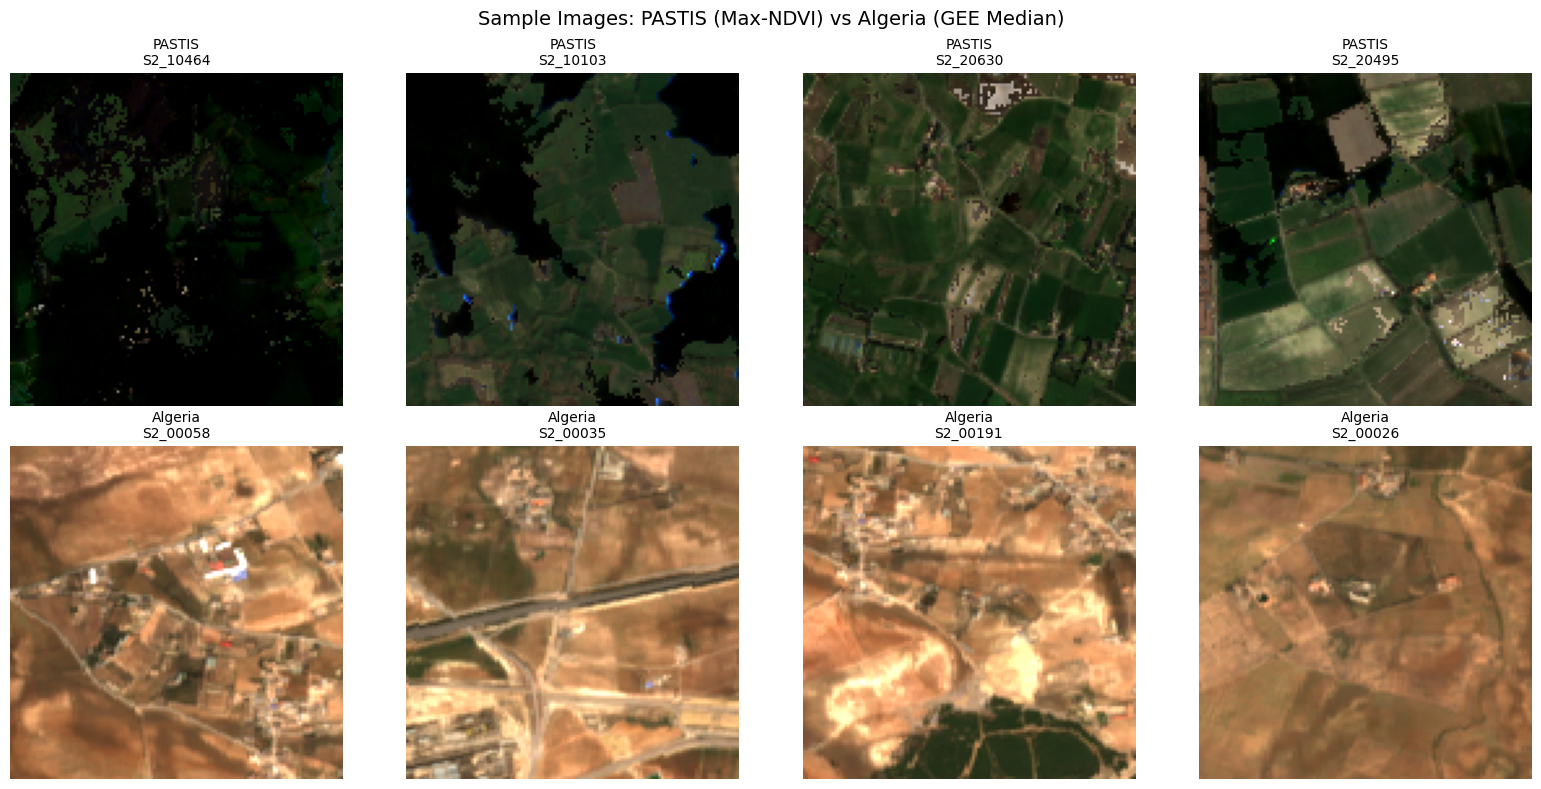

In [15]:
# Visualize sample images from both datasets
import matplotlib.pyplot as plt
import random

# Load some PASTIS Max-NDVI samples
pastis_dir = Path('/home/crop/Desktop/crop/output/pastis_maxndvi/DATA_S2')
algeria_dir = Path('/home/crop/Desktop/crop/output/algeria_s2_data/DATA_S2')

pastis_files = sorted(pastis_dir.glob('*.npy'))
algeria_files = sorted(algeria_dir.glob('*.npy'))

# Select random samples
random.seed(42)
pastis_samples = random.sample(pastis_files, 4)
algeria_samples = random.sample(algeria_files, min(4, len(algeria_files)))

fig, axes = plt.subplots(2, 4, figsize=(16, 8))

# Plot PASTIS samples (top row)
for i, f in enumerate(pastis_samples):
    data = np.load(f)
    # Create RGB composite (B4=Red, B3=Green, B2=Blue -> indices 2, 1, 0)
    rgb = np.stack([
        data[0, 2, :, :],  # Red
        data[0, 1, :, :],  # Green
        data[0, 0, :, :]   # Blue
    ], axis=-1)
    rgb = np.clip(rgb / 3000, 0, 1)
    axes[0, i].imshow(rgb)
    axes[0, i].set_title(f'PASTIS\n{f.stem}', fontsize=10)
    axes[0, i].axis('off')

# Plot Algeria samples (bottom row)
for i, f in enumerate(algeria_samples):
    data = np.load(f)
    rgb = np.stack([
        data[0, 2, :, :],  # Red
        data[0, 1, :, :],  # Green
        data[0, 0, :, :]   # Blue
    ], axis=-1)
    rgb = np.clip(rgb / 3000, 0, 1)
    axes[1, i].imshow(rgb)
    axes[1, i].set_title(f'Algeria\n{f.stem}', fontsize=10)
    axes[1, i].axis('off')

plt.suptitle('Sample Images: PASTIS (Max-NDVI) vs Algeria (GEE Median)', fontsize=14)
plt.tight_layout()
plt.show()

/tmp/ipykernel_17667/2674307391.py:29: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


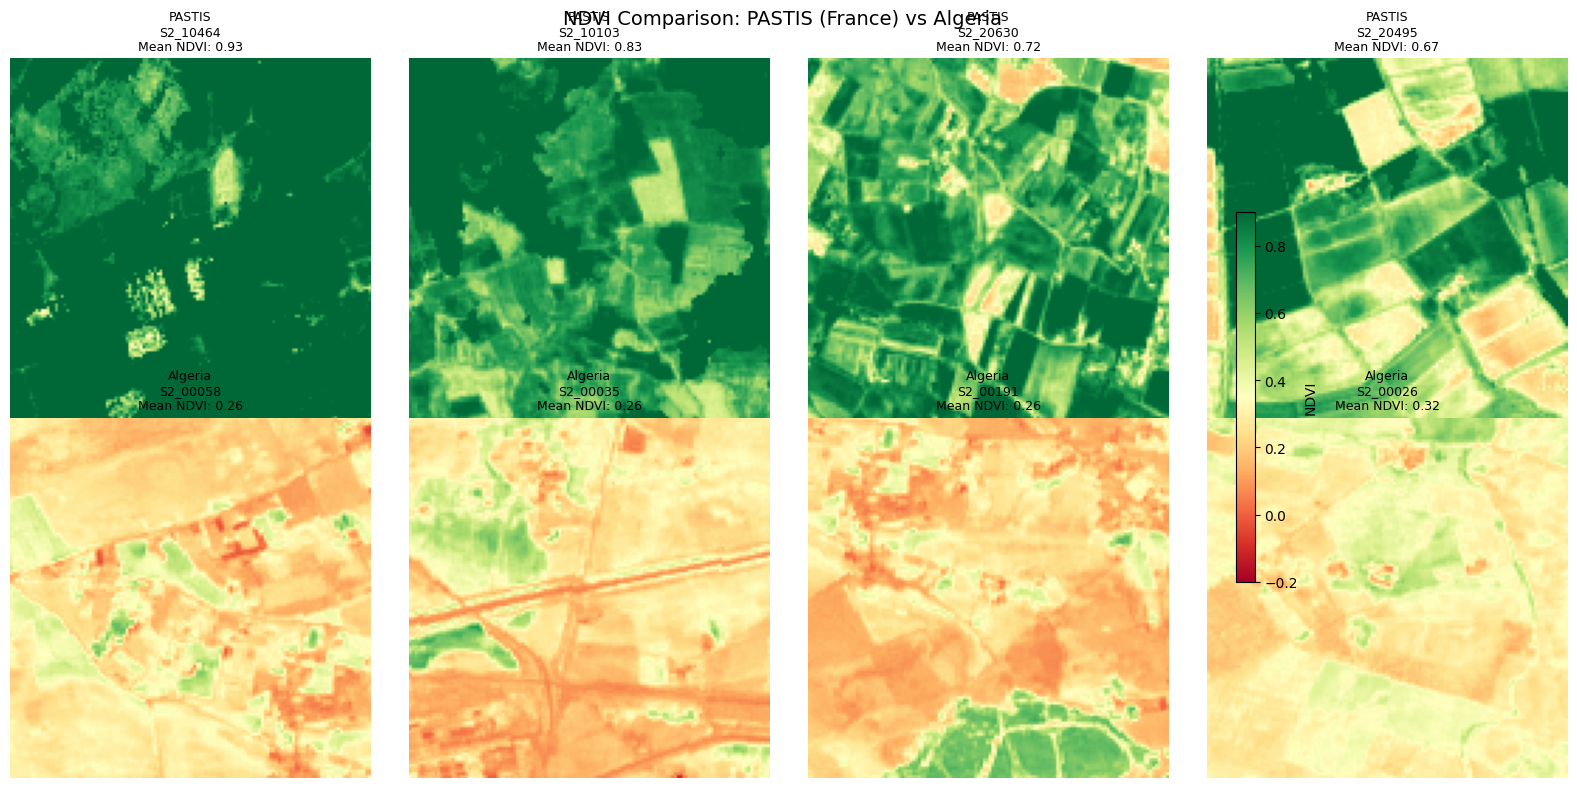


Observations:
- PASTIS (France): Higher vegetation coverage, more agricultural parcels
- Algeria: More arid/semi-arid conditions, less vegetation (lower NDVI)


In [16]:
# Visualize NDVI comparison between PASTIS and Algeria
fig, axes = plt.subplots(2, 4, figsize=(16, 8))

def compute_ndvi_single(data):
    """Compute NDVI from single image (1, 10, 128, 128)"""
    red = data[0, 2, :, :].astype(np.float32)  # B4
    nir = data[0, 6, :, :].astype(np.float32)  # B8
    return (nir - red) / (nir + red + 1e-8)

# PASTIS NDVI (top row)
for i, f in enumerate(pastis_samples):
    data = np.load(f)
    ndvi = compute_ndvi_single(data)
    im = axes[0, i].imshow(ndvi, cmap='RdYlGn', vmin=-0.2, vmax=0.9)
    axes[0, i].set_title(f'PASTIS\n{f.stem}\nMean NDVI: {ndvi.mean():.2f}', fontsize=9)
    axes[0, i].axis('off')

# Algeria NDVI (bottom row)
for i, f in enumerate(algeria_samples):
    data = np.load(f)
    ndvi = compute_ndvi_single(data)
    im = axes[1, i].imshow(ndvi, cmap='RdYlGn', vmin=-0.2, vmax=0.9)
    axes[1, i].set_title(f'Algeria\n{f.stem}\nMean NDVI: {ndvi.mean():.2f}', fontsize=9)
    axes[1, i].axis('off')

# Add colorbar
fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.6, label='NDVI')
plt.suptitle('NDVI Comparison: PASTIS (France) vs Algeria', fontsize=14)
plt.tight_layout()
plt.show()

print("\nObservations:")
print("- PASTIS (France): Higher vegetation coverage, more agricultural parcels")
print("- Algeria: More arid/semi-arid conditions, less vegetation (lower NDVI)")